In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import tensorflow as tf
import time
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import configparser
%matplotlib inline

# DIGITS DATASET


In [2]:
config = configparser.ConfigParser()
config.read('config.ini')
SOURCE_IMAGE=config['Data']['digits']
DATASET_FOLDER=config['Data']['dataset']

### resize image and invert colors

In [3]:
folder_names=[1,2,3,4,5,6,7,8,9]
def image_preprocessing(names=folder_names,source_folder=SOURCE_IMAGE, destination_folder=DATASET_FOLDER, threshold=True):
    for folder_name in names:
        folder=f"{source_folder}\\{folder_name}"
        for i in os.listdir(folder):
            file = f"{folder}\\{i}"
            img = cv2.imread(file)
            img = cv2.resize(img,(50, 50))
            if(threshold):
                _,img=cv2.threshold(img,127,255,cv2.THRESH_BINARY_INV)
            dest_file=f"{destination_folder}\\{folder_name}\\{i}"
            cv2.imwrite(dest_file,img)

image_preprocessing()

In [32]:
augmented_image_gen = ImageDataGenerator(
    rotation_range=3,
    width_shift_range=.15,
    height_shift_range=.15,
    zoom_range=0.1,
    shear_range=1,
    brightness_range=[0.9, 1.2],
    validation_split=0.15,
    #samplewise_center=True,
    #samplewise_std_normalization=True,
    fill_mode='constant',
    cval=0)

normal_image_gen = ImageDataGenerator(
    validation_split=0.15,
    #samplewise_center=True,
    #samplewise_std_normalization=True
)

In [30]:
BATCH_SIZE=64
IMG_H = 50
IMG_W = 50

In [33]:
train_data_gen = augmented_image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                                    directory=DATASET_FOLDER,
                                                    color_mode="grayscale",
                                                    shuffle=True,
                                                    target_size=(IMG_H, IMG_W),
                                                    class_mode="categorical",
                                                    seed=65657867,
                                                    subset='training'                                              
                                                    )
val_data_gen  = normal_image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                                    directory=DATASET_FOLDER,
                                                    color_mode="grayscale",
                                                    shuffle=True,
                                                    target_size=(IMG_H, IMG_W),
                                                    class_mode="categorical",
                                                    seed=65657867,
                                                    subset='validation'
                                                    )

Found 7694 images belonging to 9 classes.
Found 1351 images belonging to 9 classes.


train_dataset=tf.keras.preprocessing.image_dataset_from_directory(
    directory=DATASET_FOLDER,
    labels="inferred",
    label_mode="int",
    color_mode="grayscale",
    image_size=(img_height, img_width),
    seed=123,
    batch_size=64,
    validation_split=0.15,
    subset="training")

validation_dataset=tf.keras.preprocessing.image_dataset_from_directory(
    directory=DATASET_FOLDER,
    labels="inferred",
    label_mode="int",
    color_mode="grayscale",
    image_size=(img_height, img_width),
    seed=123,
    batch_size=64,
    validation_split=0.15,
    subset="validation")



In [27]:
import matplotlib.pyplot as plt

# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plot_images(images_arr, imageWidth, imageHeight):
    fig, axes = plt.subplots(2, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img.reshape(imageWidth, imageHeight), cmap="gray")
        ax.axis("off")
    plt.tight_layout()
    plt.show()

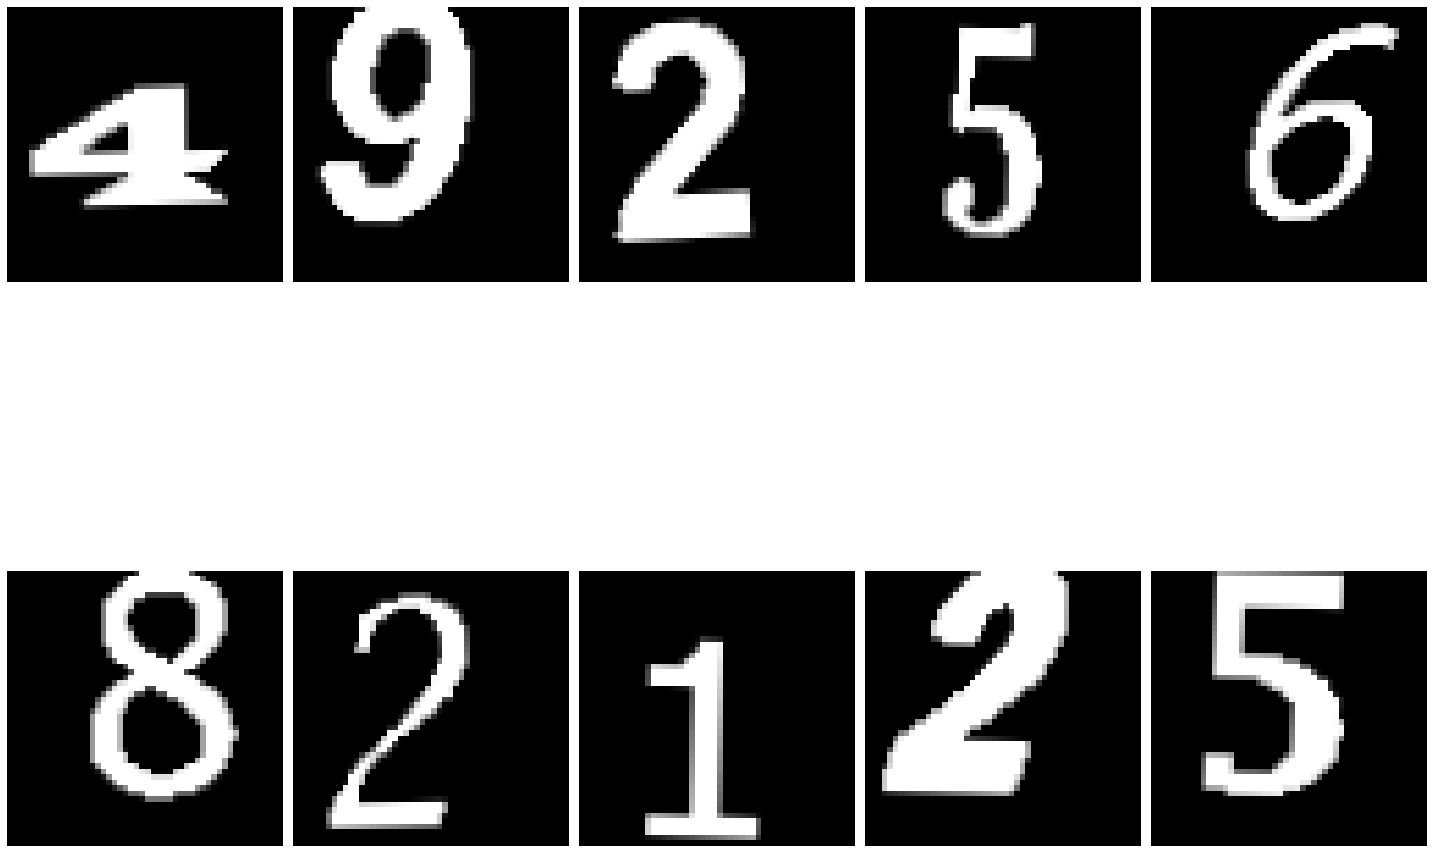

In [34]:
sample_training_images, _ = next(train_data_gen)
plot_images(sample_training_images[:10], IMG_W, IMG_H)

In [35]:
num_classes = 9

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255,input_shape=(IMG_H,IMG_W,1)),
  tf.keras.layers.Conv2D(32, 5, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(5, 5)),
  tf.keras.layers.Conv2D(64, 5, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(5, 5)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(60, activation='relu'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(num_classes,activation='softmax')
])

In [36]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [37]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 50, 50, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 32)        832       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 64)        51264     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)              

In [38]:
epochs=50

history = model.fit(
  train_data_gen,
  steps_per_epoch=train_data_gen.samples // (BATCH_SIZE*1.5),
  validation_data=val_data_gen,
  validation_steps=val_data_gen.samples // (BATCH_SIZE*1.5),
  epochs=epochs
)

Epoch 1/50
80/80 [==============================] - 13s 164ms/step - loss: 1.7422 - accuracy: 0.3718 - val_loss: 0.4564 - val_accuracy: 0.9375
Epoch 2/50
80/80 [==============================] - 15s 182ms/step - loss: 0.5721 - accuracy: 0.8133 - val_loss: 0.1053 - val_accuracy: 0.9732
Epoch 3/50
80/80 [==============================] - 13s 159ms/step - loss: 0.2876 - accuracy: 0.9113 - val_loss: 0.0533 - val_accuracy: 0.9877
Epoch 4/50
80/80 [==============================] - 13s 159ms/step - loss: 0.2036 - accuracy: 0.9359 - val_loss: 0.0455 - val_accuracy: 0.9877
Epoch 5/50
80/80 [==============================] - 13s 162ms/step - loss: 0.1602 - accuracy: 0.9471 - val_loss: 0.0268 - val_accuracy: 0.9888
Epoch 6/50
80/80 [==============================] - 9s 115ms/step - loss: 0.1373 - accuracy: 0.9546 - val_loss: 0.0193 - val_accuracy: 0.9955
Epoch 7/50
80/80 [==============================] - 9s 112ms/step - loss: 0.1111 - accuracy: 0.9646 - val_loss: 0.0173 - val_accuracy: 0.9955
E

In [39]:
numbers_for_predictions_SUDOKU=range(0,33)
values_SUDOKU=[8,1,9,5,8,7,1,4,9,7,6,7,1,2,5,8,6,1,7,1,5,2,9,7,4,6,8,3,9,4,3,5,8]

numbers_for_predictions_1006=range(0,24)
values_1006=[9,5,8,2,3,4,7,2,3,4,8,2,5,1,6,4,3,7,6,4,5,9,2,6]

total_time=0

predictions=[]
for index,value in zip(numbers_for_predictions_SUDOKU,values_SUDOKU):    
    file_name=(f"F:\\ML Projects\\CUBIC Praksa\\SudokuSolver\\Data\\TestCells\\{index}.jpg")
    img=cv2.imread(file_name,cv2.IMREAD_GRAYSCALE)
    _,img=cv2.threshold(img,127,255,cv2.THRESH_BINARY)
    img_array = np.reshape(img,(1,50,50,1))
    start=time.time()
    prediction = model.predict_on_batch(img_array)
    total_time+=(time.time()-start)
    score = tf.nn.softmax(prediction[0])
    predicted_class=int(int(np.argmax(score)+1))
    
    predictions.append(predicted_class)
    if(predicted_class!=value):
        print(f"ERROR AT INDEX:{index}")
        print(predicted_class,value)
    
print(predictions)
        

[8, 1, 9, 5, 8, 7, 1, 4, 9, 7, 6, 7, 1, 2, 5, 8, 6, 1, 7, 1, 5, 2, 9, 7, 4, 6, 8, 3, 9, 4, 3, 5, 8]


In [40]:
total_time

0.24027705192565918

In [41]:
model.save("ocr_model_v1_gen")

INFO:tensorflow:Assets written to: ocr_model_v1_gen\assets


# MNIST DATASET

SOURCE_IMAGE_MNIST="F:\\ML Projects\\CUBIC Praksa\\ARSudokuSolver\\Data\\MNIST\\trainingSet"
DATASET_FOLDER_MNIST="F:\\ML Projects\\CUBIC Praksa\\ARSudokuSolver\\Data\\DatasetMNIST"

image_preprocessing(source_folder=SOURCE_IMAGE_MNIST,destination_folder=DATASET_FOLDER_MNIST, threshold=False)

img_height = 50
img_width = 50

train_dataset_MNIST=tf.keras.preprocessing.image_dataset_from_directory(
    directory=DATASET_FOLDER_MNIST,
    labels="inferred",
    label_mode="int",
    color_mode="grayscale",
    image_size=(img_height, img_width),
    seed=123,
    batch_size=32,
    validation_split=0.15,
    subset="training")

validation_dataset_MNIST=tf.keras.preprocessing.image_dataset_from_directory(
    directory=DATASET_FOLDER_MNIST,
    labels="inferred",
    label_mode="int",
    color_mode="grayscale",
    image_size=(img_height, img_width),
    seed=123,
    batch_size=32,
    validation_split=0.15,
    subset="validation")

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_dataset_MNIST.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
        plt.axis("off")

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_dataset_MNIST.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = validation_dataset_MNIST.cache().prefetch(buffer_size=AUTOTUNE)

epochs=5

history = model.fit(
    train_dataset_MNIST,
  validation_data=validation_dataset_MNIST,
  epochs=epochs
)

numbers_for_predictions_SUDOKU=[0,4,8,10,12,14,16,20,22,24,28,30,32,34,36,38,40,42,44,46,48,50,52,56,58,60,64,66,68,70,72,76,80]
values_SUDOKU=[8,1,9,5,8,7,1,4,9,7,6,7,1,2,5,8,6,1,7,1,5,2,9,7,4,6,8,3,9,4,3,5,8]

numbers_for_predictions_1006=range(0,24)
values_1006=[9,5,8,2,3,4,7,2,3,4,8,2,5,1,6,4,3,7,6,4,5,9,2,6]

predictions=[]
for index,value in zip(numbers_for_predictions_SUDOKU,values_SUDOKU):    
    file_name=f"F:\\ML Projects\\CUBIC Praksa\\ARSudokuSolver\\Data\\testCells\\{index}.jpg"
    img = keras.preprocessing.image.load_img(file_name, target_size=(img_height, img_width),color_mode='grayscale')
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    prediction = model.predict(img_array)
    score = tf.nn.softmax(prediction[0])
    predicted_class=int(np.argmax(score))+1
    predictions.append(predicted_class)
    if(predicted_class!=value):
        print(f"ERROR AT INDEX:{index}")
        

print(values_SUDOKU)
print(predictions)